In [1]:
!git clone https://github.com/openai/shap-e

fatal: destination path 'shap-e' already exists and is not an empty directory.


In [2]:
!pip install pickleshare
!pip install -e .
!pip install googletrans==4.0.0-rc1
!pip install matplotlib
!pip install scikit-learn

DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\future-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\hydra_core-0.11.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\omegaconf-1.4.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\a

Obtaining file:///C:/Users/gerpv/Desktop/predpp/preddippract


DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\future-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\hydra_core-0.11.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\omegaconf-1.4.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\a

DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\future-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\hydra_core-0.11.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\omegaconf-1.4.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\a

DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\future-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\hydra_core-0.11.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\omegaconf-1.4.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\a

DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\future-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\hydra_core-0.11.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\omegaconf-1.4.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\a

In [3]:
%cd shap-e

c:\Users\gerpv\Desktop\predpp\preddippract\shap-e


In [5]:
!pip install -e .
!pip install googletrans==4.0.0-rc1
!pip install matplotlib
!pip install scikit-learn

Obtaining file:///C:/Users/gerpv/Desktop/predpp/preddippract/shap-e
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/openai/CLIP.git to c:\users\gerpv\appdata\local\temp\pip-install-6cc8_m6v\clip_57f57ee3aafe4af192925a9fcafedc54
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: shap-e
    Found existing installation: shap-e 0.0.0
    Uninstalling shap-e-0.0.0:
      Successfully uninstalled shap-e-0.0.0
  Running setup.py develop for shap-e


DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\future-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\hydra_core-0.11.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\omegaconf-1.4.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\a

DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\future-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\hydra_core-0.11.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\omegaconf-1.4.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\a

DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\future-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\hydra_core-0.11.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\omegaconf-1.4.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\a

DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\future-1.0.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\hydra_core-0.11.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\appdata\local\programs\python\python312\lib\site-packages\omegaconf-1.4.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\gerpv\a

In [4]:
import torch
import ipywidgets as widgets
from IPython.display import display
#from google.colab import files
from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget
from googletrans import Translator
import imageio
import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu118
True


In [6]:
# Выбор устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Вывод сообщения о выбранном устройстве
if device.type == 'cuda':
    print(f"Выбрано устройство: {device.type.upper()} (GPU)")
else:
    print(f"Выбрано устройство: {device.type.upper()} (CPU)")

Выбрано устройство: CUDA (GPU)


In [7]:
xm = load_model('transmitter', device=device)
model = load_model('text300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))
# Создаем объект переводчика
translator = Translator()

# Функция для перевода текста с русского на английский
def translate_to_english(text):
    translation = translator.translate(text, src='ru', dest='en')
    return translation.text

c:\Users\gerpv\Desktop\predpp\preddippract\shap-e\shap_e\models\nn\checkpoint.py:31: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
c:\Users\gerpv\Desktop\predpp\preddippract\shap-e\shap_e\models\nn\checkpoint.py:43: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
c:\Users\gerpv\Desktop\predpp\preddippract\shap-e\shap_e\models\nn\checkpoint.py:61: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
c:\Users\gerpv\Desktop\predpp\preddippract\shap-e\shap_e\models\nn\checkpoint.py:86: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
c:\Users\gerpv\Desktop\predpp\preddippract\shap-

In [9]:
batch_size = 1
guidance_scale = 15.0
prompt = "a red plane"

latents = sample_latents(
    batch_size=batch_size,
    model=model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(texts=[prompt] * batch_size),
    progress=True,
    clip_denoised=True,
    use_fp16=True,
    use_karras=True,
    karras_steps=64,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
).to(device)  # Перемещаем латентные представления на устройство CUDA

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
render_mode = 'nerf' 
size = 64 # это размер рендера; более высокие значения займут больше времени для рендера.

cameras = create_pan_cameras(size, device)
for i, latent in enumerate(latents):
    images = decode_latent_images(xm, latent.to(device), cameras, rendering_mode=render_mode)  # Перемещаем латентные представления на устройство CUDA
    display(gif_widget(images))

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAAPMAAPIAAPEAAO8AAO4AAOwAAOsAAOoAAOkAAOcAAOYAAOUAAO…

  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAAPIAAPEAAPAAAO8AAO4AAO0AAOwAAOsAAOoAAOkAAOgAAOcAAO…

GIF сохранен в generated_gif.gif


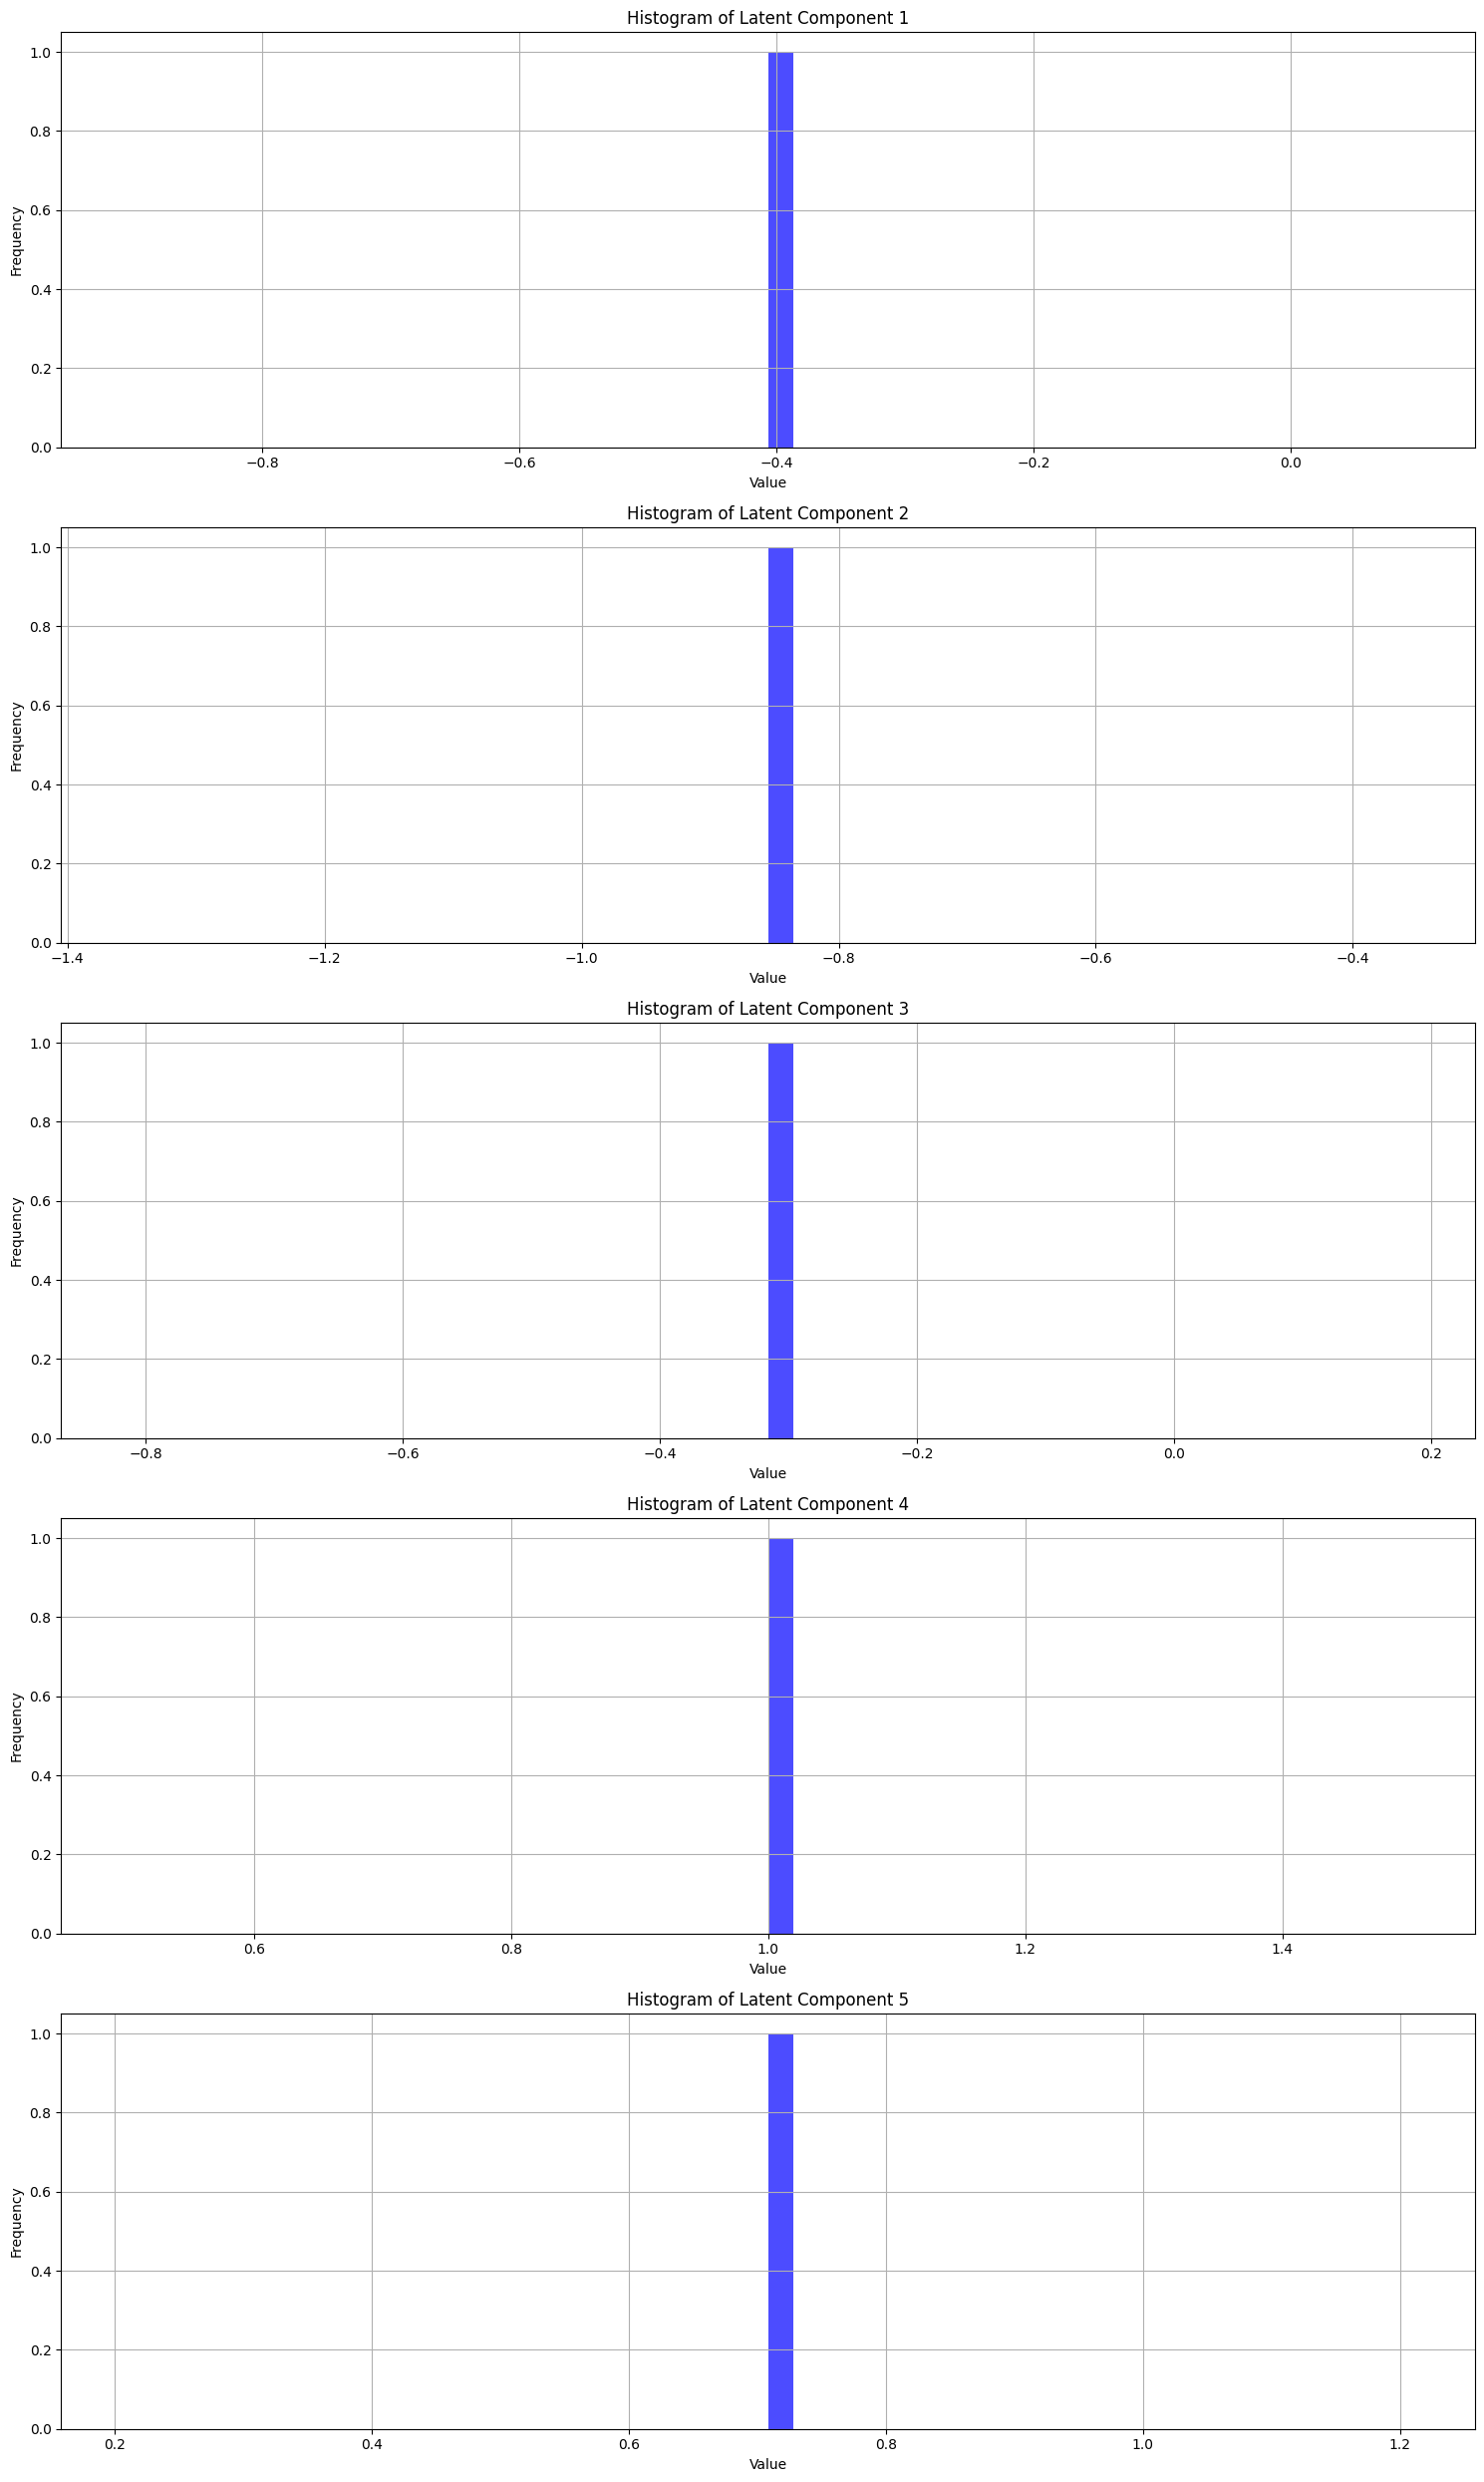

  0%|          | 0/64 [00:00<?, ?it/s]

HTML(value='<img src="data:image/gif;base64,R0lGODlhQABAAIYAANyrpNUJAOYAAOUAAOQAAOMAAOIAAOEAAOAAAN8AAN4AAN0AAN…

In [12]:
# Инициализация переводчика
translator = Translator()

# Функция для перевода текста с русского на английский
def translate_to_english(text):
    translation = translator.translate(text, src='ru', dest='en')
    return translation.text

# Создание виджетов для ввода параметров
prompt_widget = widgets.Text(value='красный самолет', description='Prompt:', disabled=False)
guidance_scale_widget = widgets.FloatSlider(value=15.0, min=1.0, max=30.0, step=0.1, description='Guidance Scale:', disabled=False)
render_mode_widget = widgets.Dropdown(options=['nerf', 'stf'], value='nerf', description='Render Mode:', disabled=False)
size_widget = widgets.IntSlider(value=64, min=32, max=256, step=1, description='Size:', disabled=False)

# Создание кнопки для начала генерации
generate_button = widgets.Button(description="Generate")

# Создание кнопки для сохранения GIF
save_button = widgets.Button(description="Save GIF")

# Создание кнопки для отображения гистограммы
histogram_button = widgets.Button(description="Show Histogram")

# Инициализация переменных для хранения сгенерированных изображений и латентных представлений
generated_images = []
generated_latents = None

# Определение функции, которая будет вызываться при нажатии на кнопку генерации
def on_generate_button_clicked(b):
    global generated_images, generated_latents
    prompt = prompt_widget.value
    translated_prompt = translate_to_english(prompt)
    guidance_scale = guidance_scale_widget.value
    render_mode = render_mode_widget.value
    size = size_widget.value

    latents = sample_latents(
        batch_size=batch_size,
        model=model,
        diffusion=diffusion,
        guidance_scale=guidance_scale,
        model_kwargs=dict(texts=[translated_prompt] * batch_size),
        progress=True,
        clip_denoised=True,
        use_fp16=True,
        use_karras=True,
        karras_steps=64,
        sigma_min=1e-3,
        sigma_max=160,
        s_churn=0,
    ).to(device)  # Перемещаем латентные представления на устройство CUDA

    generated_latents = latents

    cameras = create_pan_cameras(size, device)
    generated_images = []
    for i, latent in enumerate(latents):
        images = decode_latent_images(xm, latent.to(device), cameras, rendering_mode=render_mode)  # Перемещаем латентные представления на устройство CUDA
        generated_images.append(images)
        display(gif_widget(images))

# Определение функции, которая будет вызываться при нажатии на кнопку сохранения
def on_save_button_clicked(b):
    if generated_images:
        output_path = 'generated_gif.gif'
        imageio.mimsave(output_path, generated_images[0], fps=10)
        print(f"GIF сохранен в {output_path}")
        # Создание ссылки для скачивания сохраненного GIF
        #files.download(output_path)
    else:
        print("Изображения еще не сгенерированы. Пожалуйста, сначала сгенерируйте изображения.")

# Функция для визуализации латентных представлений
def visualize_latents(latents):
    # Проверка размерности латентных представлений
    if latents.ndimension() == 1:
        # Если латентные представления одномерные, визуализируем их гистограмму
        plt.figure(figsize=(10, 5))
        plt.hist(latents.cpu().numpy(), bins=50, color='blue', alpha=0.7)
        plt.title('Histogram of Latent Representations')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    else:
        # Если латентные представления многомерные, визуализируем гистограммы для каждого компонента
        num_components = min(latents.shape[1], 5)  # Визуализируем первые 5 компонентов
        plt.figure(figsize=(15, 5 * num_components))
        for i in range(num_components):
            plt.subplot(num_components, 1, i + 1)
            plt.hist(latents[:, i].cpu().numpy(), bins=50, color='blue', alpha=0.7)
            plt.title(f'Histogram of Latent Component {i + 1}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

# Определение функции, которая будет вызываться при нажатии на кнопку отображения гистограммы
def on_histogram_button_clicked(b):
    if generated_latents is not None:
        visualize_latents(generated_latents)
    else:
        print("Латентные представления еще не сгенерированы. Пожалуйста, сначала сгенерируйте изображения.")

# Привязка функций к кнопкам
generate_button.on_click(on_generate_button_clicked)
save_button.on_click(on_save_button_clicked)
histogram_button.on_click(on_histogram_button_clicked)

# Создание разделов для организации интерфейса
input_section = widgets.VBox([prompt_widget, guidance_scale_widget, render_mode_widget, size_widget])
button_section = widgets.HBox([generate_button, save_button, histogram_button])

# Отображение виджетов и кнопок
display(input_section, button_section)